# Práctica 2 - Interligencia Artificial

#### Autores: Andreu Marqués Valerià y Álvaro Pimentel Lorente
#### Fecha: 12/12/2020




In [341]:
import numpy as np 
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

## Lectura de datos

Per llegir les dades emprarem la llibreria de ``pandas``. El fitxer en qüestió és el fitxer que heu descarregat de Kaggle.

In [342]:
df_train = pd.read_csv('dades.csv')
pd.set_option('display.max_columns', None)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Tratado de valores nulos (``Nan``)

Eliminamos las columnas ``PassengerId``, ``Name`` y ``Ticket`` ya que no aportan información relevante para el entrenamiento del modelo.

In [343]:
df_train.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


A continuación buscamos en qué columnas existen valores ``Nan``. Como se puede observar, únicamente existen 3 columnas con valores nulos: ``Age``, ``Cabin`` y ``Embarked``

In [344]:
df_train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

La columna ``Cabin`` tiene muchos valores nulos, por lo que una opción sería eliminarla. Sin embargo, nos aporta infomación sobre si el pasajero tiene camarote a su nombre o no. Por lo tanto, sustituiremos los valores nulos por ``0`` y los valores no nulos por ``1``.

In [345]:
HasCabin = df_train['Cabin'].notnull().astype('int')
df_train['Cabin'] = HasCabin
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,0,S
1,1,1,female,38.0,1,0,71.2833,1,C
2,1,3,female,26.0,0,0,7.9250,0,S
3,1,1,female,35.0,1,0,53.1000,1,S
4,0,3,male,35.0,0,0,8.0500,0,S


Continuamos con la columna ``Age`` que tiene algunos valores ``Nan``. En este caso, sustituiremos aquellos valores nulos por la mediana de los valores de la columna ``Age``

In [346]:
df_train['Age'].fillna(df_train['Age'].median(), inplace = True)


En el caso de la columna ``Embarked``, aplicaremos el mismo proceso anterior. Para determinar el valor con el que reemplazar los valores faltantes, se llama al método mode en la columna ``Embarked``. Este método devuelve el valor más frecuente de la columna, que en este caso es el valor más comúnmente embarcado por los pasajeros.

In [347]:
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace = True)

## Conversión de valores y columnas

Convertirmos la columna ``Sex`` a numérica, ya que el modelo no puede trabajar con datos categóricos. Para ello, sustituimos los valores ``male`` por ``0`` y ``female`` por ``1``.

In [348]:
df_train['Sex'].replace(['male','female'],[0,1],inplace=True)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,0,S
1,1,1,1,38.0,1,0,71.2833,1,C
2,1,3,1,26.0,0,0,7.9250,0,S
3,1,1,1,35.0,1,0,53.1000,1,S
4,0,3,0,35.0,0,0,8.0500,0,S


Realizamos una matriz de correlación para observar qué variables están más correlacionadas entre sí. En este caso, podemos observar que las variables más correlacionadas con la variable ``Survived`` son ``Sex``, ``Pclass``, ``Cabin`` y ``Fare`` (en ese orden).

In [349]:
corr = abs(df_train.corr())
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
Survived,1.000000,0.338481,0.543351,0.064910,0.035322,0.081629,0.257307,0.316912
Pclass,0.338481,1.000000,0.131900,0.339898,0.083081,0.018443,0.549500,0.725541
Sex,0.543351,0.131900,1.000000,0.081163,0.114631,0.245489,0.182333,0.140391
Age,0.064910,0.339898,0.081163,1.000000,0.233296,0.172482,0.096688,0.240314
SibSp,0.035322,0.083081,0.114631,0.233296,1.000000,0.414838,0.159651,0.040460
Parch,0.081629,0.018443,0.245489,0.172482,0.414838,1.000000,0.216225,0.036987
Fare,0.257307,0.549500,0.182333,0.096688,0.159651,0.216225,1.000000,0.482075
Cabin,0.316912,0.725541,0.140391,0.240314,0.040460,0.036987,0.482075,1.000000


A continuación, será necesario realizar one-hot encoding de las variables categóricas ``Embarked`` y ``Pclass``. Para ello, utilizaremos la funcion ``get_dummies`` de ``pandas``.

In [350]:
df_onehot_Pclass = pd.get_dummies(df_train['Pclass'], prefix='Pclass')

df_onehot_Embarked = pd.get_dummies(df_train['Embarked'], prefix='Embarked')

df_onehot_Embarked.head()

df_train = pd.concat([df_train, df_onehot_Pclass, df_onehot_Embarked], axis=1)

df_train.drop(columns=['Pclass', 'Embarked'], inplace=True)

df_train.head()


,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,0,22.0,1,0,7.2500,0,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,0,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,1,0,0,0,0,1
4,0,0,35.0,0,0,8.0500,0,0,0,1,0,0,1


A continuación, combinaremos las columnas SibSp y Parch

In [351]:
df_train['Familiars'] = df_train['SibSp'] + df_train['Parch'] + 1

df_train.drop(columns=['SibSp', 'Parch'], inplace=True)

df_train

,Survived,Sex,Age,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Familiars
0,0,0,22.0,7.2500,0,0,0,1,0,0,1,2
1,1,1,38.0,71.2833,1,1,0,0,1,0,0,2
2,1,1,26.0,7.9250,0,0,0,1,0,0,1,1
3,1,1,35.0,53.1000,1,1,0,0,0,0,1,2
4,0,0,35.0,8.0500,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,13.0000,0,0,1,0,0,0,1,1
887,1,1,19.0,30.0000,1,1,0,0,0,0,1,1
888,0,1,28.0,23.4500,0,0,0,1,0,0,1,4
889,1,0,26.0,30.0000,1,1,0,0,1,0,0,1


In [352]:
corr = abs(df_train.corr())
corr.style.background_gradient(cmap='coolwarm')

,Survived,Sex,Age,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Familiars
Survived,1.000000,0.543351,0.064910,0.257307,0.316912,0.285904,0.093349,0.322308,0.168240,0.003650,0.149683,0.016639
Sex,0.543351,1.000000,0.081163,0.182333,0.140391,0.098013,0.064746,0.137143,0.082853,0.074115,0.119224,0.200988
Age,0.064910,0.081163,1.000000,0.096688,0.240314,0.323896,0.015831,0.291955,0.030248,0.031415,0.006729,0.245619
Fare,0.257307,0.182333,0.096688,1.000000,0.482075,0.591711,0.118557,0.413333,0.269335,0.117216,0.162184,0.217138
Cabin,0.316912,0.140391,0.240314,0.482075,1.000000,0.788773,0.172413,0.539291,0.208528,0.129572,0.101139,0.009175
Pclass_1,0.285904,0.098013,0.323896,0.591711,0.788773,1.000000,0.288585,0.626738,0.296423,0.155342,0.161921,0.046114
Pclass_2,0.093349,0.064746,0.015831,0.118557,0.172413,0.288585,1.000000,0.565210,0.125416,0.127301,0.189980,0.038594
Pclass_3,0.322308,0.137143,0.291955,0.413333,0.539291,0.626738,0.565210,1.000000,0.153329,0.237449,0.015104,0.071142
Embarked_C,0.168240,0.082853,0.030248,0.269335,0.208528,0.296423,0.125416,0.153329,1.000000,0.148258,0.782742,0.046215
Embarked_Q,0.003650,0.074115,0.031415,0.117216,0.129572,0.155342,0.127301,0.237449,0.148258,1.000000,0.499421,0.058592


## Entrenamiento del modelo

Separación del conjunto de datos en entrenamiento y test

In [353]:
df_train.drop(columns=['Embarked_C','Embarked_Q','Embarked_S'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['Survived']), df_train['Survived'], test_size=0.2)

### **Regresión Logística**

Entrenamiento del modelo de Regresion Logística

In [354]:
LogReg =  LogisticRegression(solver='lbfgs', max_iter=1000, fit_intercept=True)
LogReg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Calculamos la puntación del modelo ``LogReg``

In [355]:
LogReg.score(X_test, y_test)

0.7430167597765364

## **Random Forest**

Entrenamiento del modelo Random Forest

In [356]:
RanForest = RandomForestClassifier(n_estimators=50, max_features='sqrt')
RanForest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

A contintinuación, mediante un gráfico observamos cuales son las columnas con mayor importancia para el modelo ``RandomForest``.

<AxesSubplot:ylabel='feature'>

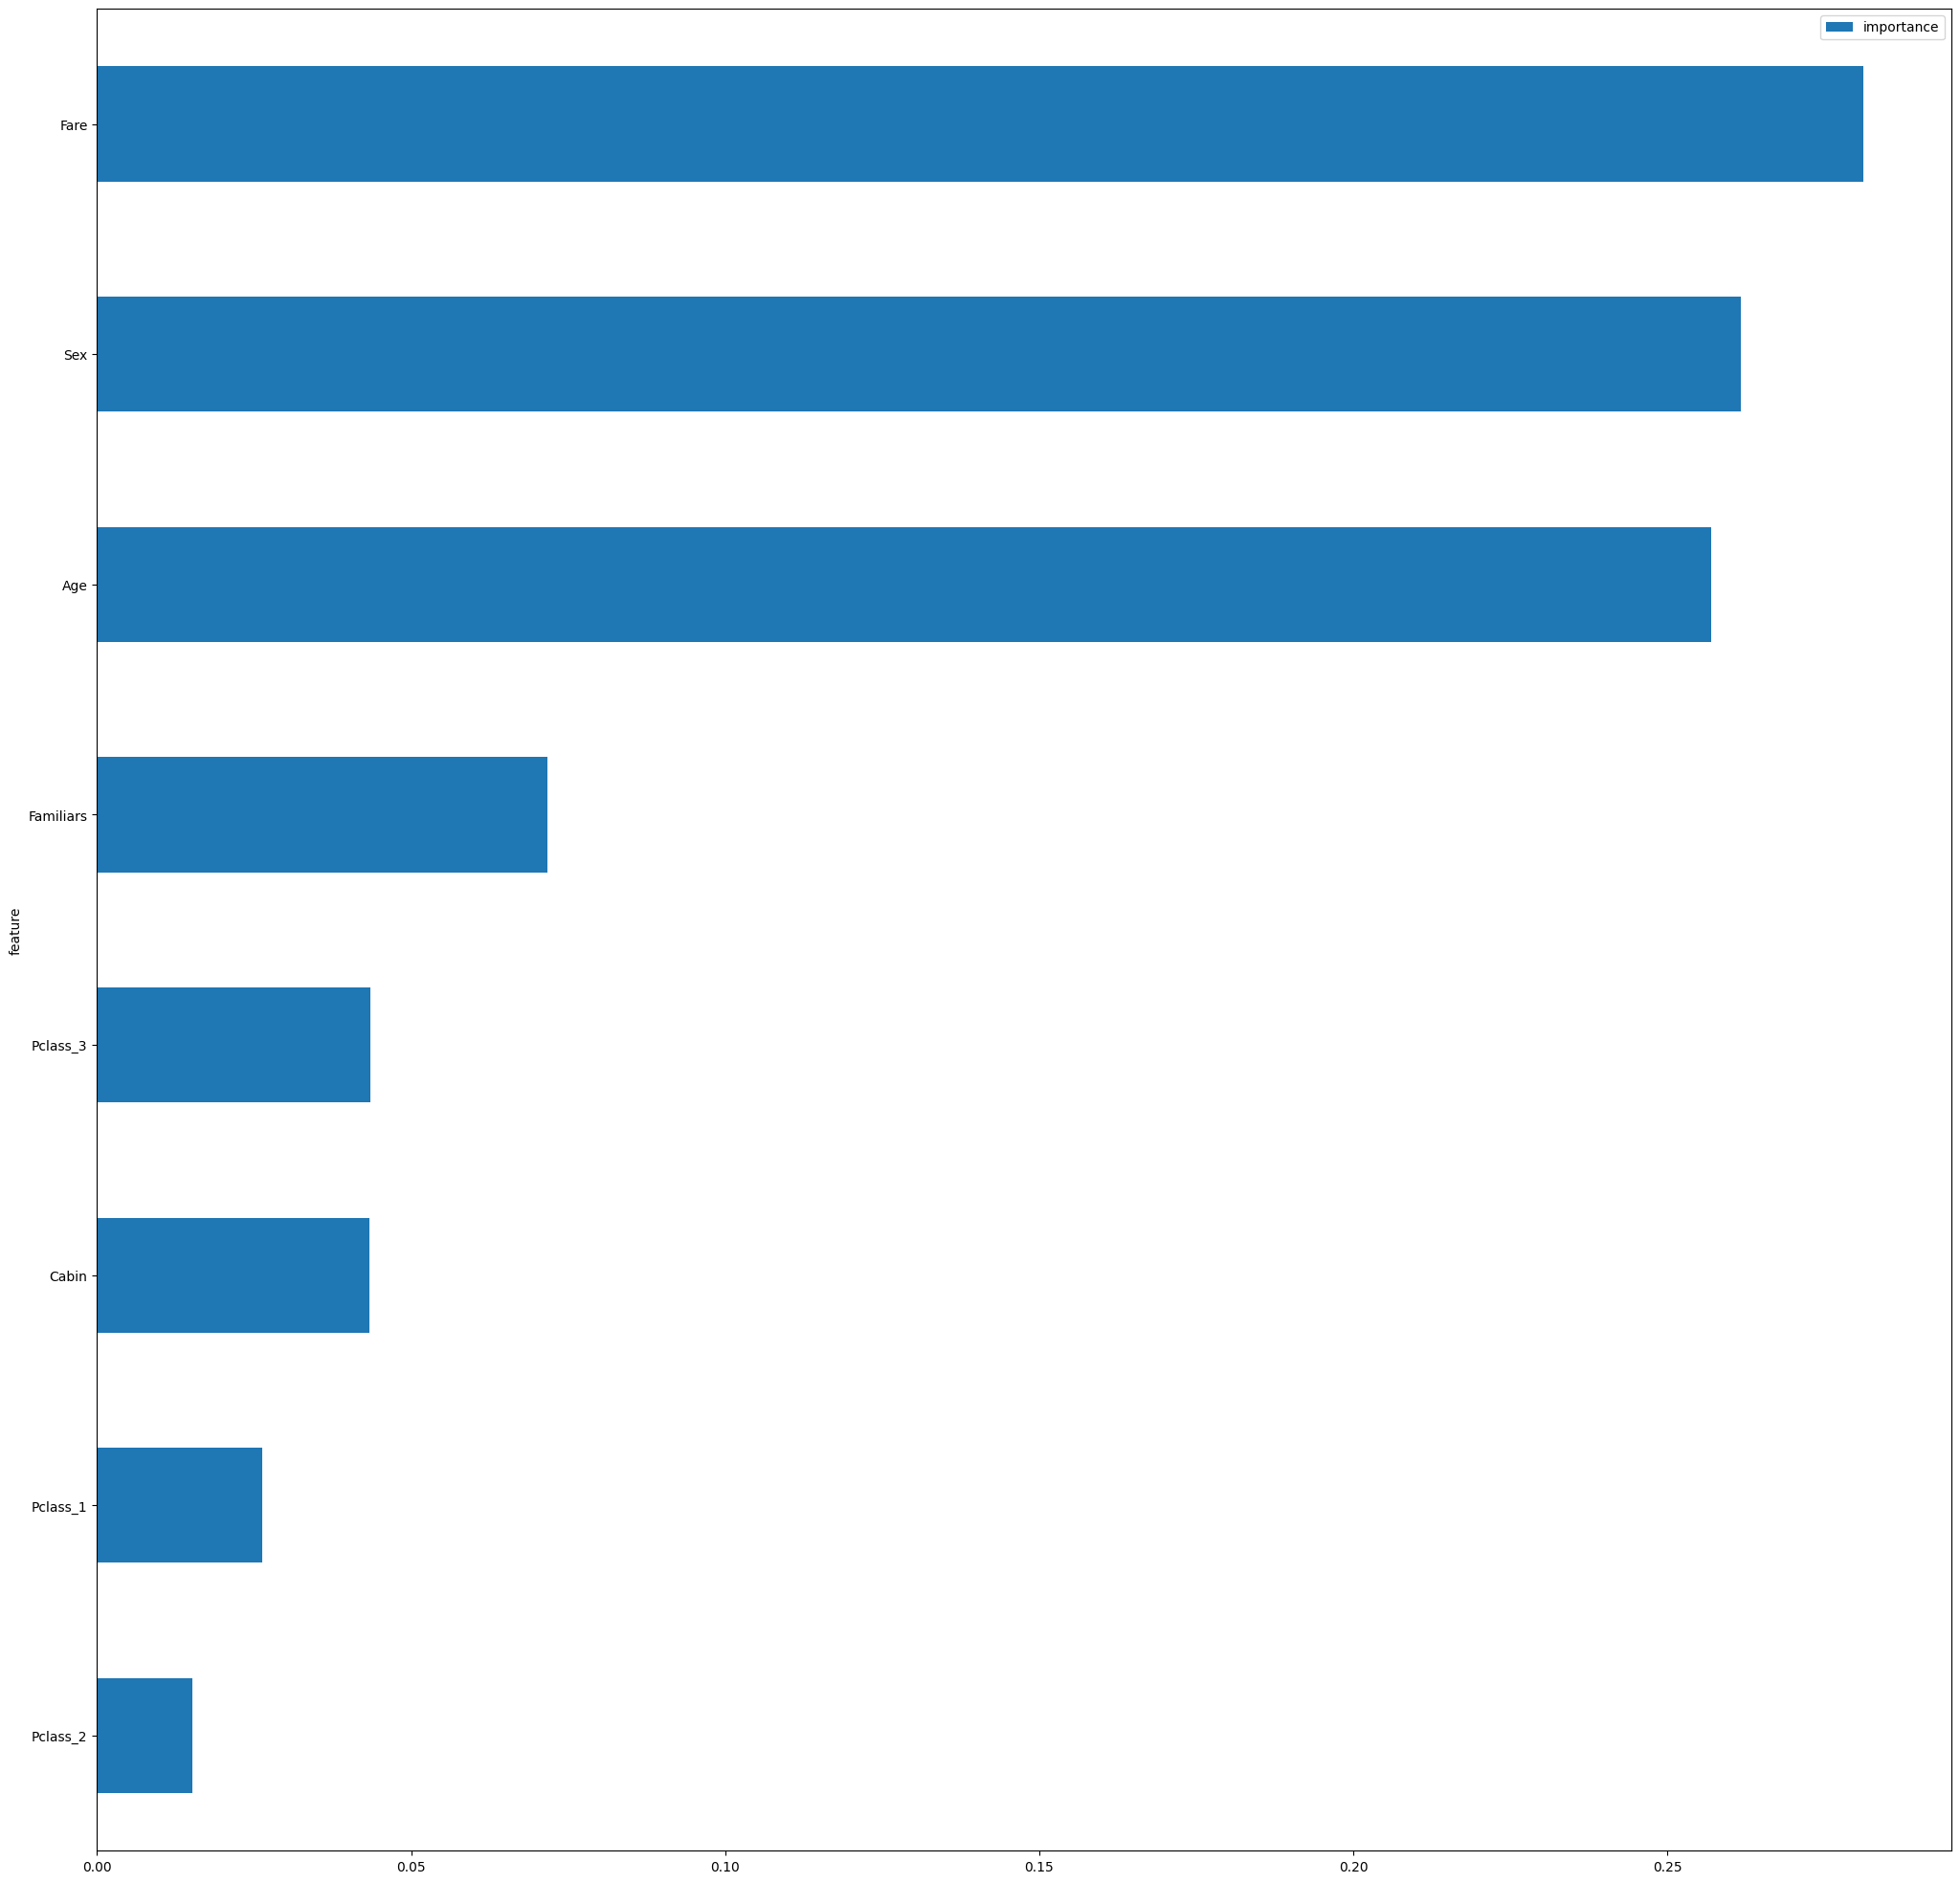

In [357]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = RanForest.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

En este caso, se puede observar que las columnas más relevantes son ``Fare``, ``Sex`` y ``Age``.

A continuación, mediante la funcion GridSearchCV, se ha realizado una búsqueda de los mejores parámetros para el modelo de Random Forest. En este caso se genera un diccionario ``parametros`` con los parámetros que se quieren probar. A continuación, se crea un objeto ``grid`` de la clase ``GridSearchCV``. Este objeto recibe como parámetros el modelo ``RandomForestClassifier``, el diccionario de parámetros ``parametros``. Para evaluar nuestro modelo, usaremos una validación cruzada de 5 veces con la precisión, ya que es la métrica que usa ``Kaggle`` la tabla de clasificación.


In [358]:
parametros = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [100, 50, 10],
                 'max_features': ['sqrt'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 'n_jobs': [-1]
                 }

gridSearch = GridSearchCV(RanForest, scoring='accuracy', param_grid=parametros, cv=5, verbose=1)

gridSearch.fit(X_train, y_train)

parameters = gridSearch.best_params_

print('Mejor puntiación: {}'.format(gridSearch.best_score_))
print('Mejores parámetros: {}'.format(gridSearch.best_params_))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Mejor puntiación: 0.8398699891657637
Mejores parámetros: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 50, 'n_jobs': -1}


Una vez realizado el entrenamiento, se obtiene el siguiente resultado:

```
Mejor puntiación: 0.8398699891657637
Mejores parámetros: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 50, 'n_jobs': -1}
```

En este caso se puede observar que el parámetro obtenido ``max_depth`` es 8, siendo este el máximo valor que se ha probado. Por lo tanto, se puede concluir que el modelo no está sobreajustado. En cuanto a los parámetros ``n_estimators``, ``min_samples_leaf``, ``min_samples_split``, se puede observar que son 3, siendo este el valor medio que se ha probado. Por lo tanto, acotaremos el valor de estos parámetros.

In [359]:
parametros = {
                 'max_depth' : [7, 8, 9],
                 'n_estimators': [75, 50, 25],
                 'max_features': ['sqrt'],
                 'min_samples_split': [3, 4],
                 'min_samples_leaf': [2, 3, 4],
                 'bootstrap': [False],
                 'n_jobs': [-1]
                 }

gridSearch = GridSearchCV(RanForest, scoring='accuracy', param_grid=parametros, cv=5, verbose=1)

gridSearch.fit(X_train, y_train)

parameters = gridSearch.best_params_

print('Mejor puntiación: {}'.format(gridSearch.best_score_))
print('Mejores parámetros: {}'.format(gridSearch.best_params_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejor puntiación: 0.8426770412685904
Mejores parámetros: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 75, 'n_jobs': -1}


Una vez realizado en tuning del modelo se obtienen los siguientes resultados:

```
Mejor puntiación: 0.8426770412685904
Mejores parámetros: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 75, 'n_jobs': -1}
```

Se puede observar que la puntuación ha incrementado y únicamente ha habido un cambio en los mejores parámetros: ``n_estimators``. Por lo tanto podemos afirmar que los otros parámetros ya están ajustados. Y únicamente queda probar diferentes valores de ``n_estimators``

In [368]:
parametros = {
                 'max_depth' : [8],
                 'n_estimators': [85, 75, 65],
                 'max_features': ['sqrt'],
                 'min_samples_split': [3],
                 'min_samples_leaf': [3],
                 'bootstrap': [False],
                 'n_jobs': [-1]
                 }

gridSearch = GridSearchCV(RanForest, scoring='accuracy', param_grid=parametros, cv=5, verbose=1)

gridSearch.fit(X_train, y_train)

parameters = gridSearch.best_params_

print('Mejor puntiación: {}'.format(gridSearch.best_score_))
print('Mejores parámetros: {}'.format(gridSearch.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejor puntiación: 0.8426770412685904
Mejores parámetros: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 75, 'n_jobs': -1}


Una vez realizado en tuning del modelo se obtienen los siguientes resultados:
```
Mejor puntiación: 0.8426770412685904
Mejores parámetros: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 75, 'n_jobs': -1}
```
Siendo estos los mismos parámetros que en la ejecución anterior, podemos afirmar que el modelo está entrenado

## **Perceptrón**